In [1]:
import gzip
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np

MONITORED_INPUT = "../results/resource-protocol-counts/monitored-counts.json.gz"
UNMONITORED_INPUT = "../results/resource-protocol-counts/unmonitored-counts.json.gz"
PLOT = "../results/plots/quic-resource-dist.pgf"

plt.style.use("./mpl-style/pets.mplstyle")

In [2]:
def load_data(path):
    """Load the number of resources retrieved with QUIC vs TCP,
    discarding blob and data resources.
    """
    with gzip.open(path) as count_file:
        result = pd.DataFrame.from_records(json.loads(line) for line in count_file)
    
    result = (result.fillna(0).set_index(["url", "req_proto"])
              .drop(columns=["data", "blob"]))
    
    quic_columns = [col for col in result.columns if "quic" in col]
    assert len(quic_columns) == 1
    print(f"Columns are: {list(result.columns)}")
    
    result["tcp"] = result.drop(columns=quic_columns).sum(axis=1) 
    result = result.rename(columns={"http/2+quic/46": "quic"})
    return result[["quic", "tcp"]].reset_index().rename(columns={"req_proto": "requested"})

In [3]:
def check_quic_requests(data):
    result = (data[(data["requested"] == "quic") & (data["quic"] == 0)]
              .groupby("url").size().sort_values(ascending=False))
    
    if len(result) > 0:
        warnings.warn("A total of {} (of {}) URLs over {} samples were requested with "
                      "QUIC but delivered with only TCP.".format(
                          len(result), data["url"].nunique(), result.sum())
                     )

In [4]:
def check_tcp_requests(data):
    result = (data[(data["requested"] == "tcp") & (data["quic"] > 0)]
              .groupby("url").size().sort_values(ascending=False))
    
    if len(result) > 0:
        warnings.warn(
            "A total of {} (of {}) URLs over {} samples were requested with TCP but had used QUIC.".format(
                len(result), data["url"].nunique(), result.sum()
            ))

In [5]:
def load_and_check_data(filename):
    data = load_data(filename)
    check_quic_requests(data)
    check_tcp_requests(data)
    
    return (data
            .set_index(["url", "requested"], append=True)
            .xs("quic", level="requested")
            .rename(columns=str.upper))

def wide(data):
    return data

def long(data):
    return data.melt(var_name="response", value_name="count")

In [6]:
monitored = load_and_check_data(MONITORED_INPUT)
display(monitored.agg(["median", "mean", "sum"]))

Columns are: ['h2', 'http/2+quic/46', 'http/1.1']


/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: A total of 1 (of 132) URLs over 120 samples were requested with QUIC but delivered with only TCP.
  


,QUIC,TCP
median,43.000000,14.000000
mean,52.949618,23.942047
sum,790326.000000,357359.000000


In [7]:
unmonitored = load_and_check_data(UNMONITORED_INPUT)
display(unmonitored.agg(["median", "mean", "sum"]))

Columns are: ['h2', 'http/2+quic/46', 'http/1.1', 'http/1.0']


/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: A total of 63 (of 17061) URLs over 171 samples were requested with QUIC but delivered with only TCP.
  


,QUIC,TCP
median,4.000000e+01,1.200000e+01
mean,5.023694e+01,1.995423e+01
sum,2.528978e+06,1.004516e+06


In [8]:
import matplotlib.ticker as mticker
    
def plot_histogram(data, ax):
    sns.histplot(data=long(data), hue="response", x="count", stat="density", binwidth=5, ax=ax,
                 palette="Dark2", hue_order=["TCP", "QUIC"], common_bins=True,
                 common_norm=True)
    ax.set_ylim(top=.021)
    ax.set_yticks([0, .01, .02])
    ax.set_xticks([0, 50, 100, 150])
    ax.set_xlabel("Number of Resources\nReturned")
    ax.get_legend().set_title(None)
    
    sns.despine(left=True, top=True, right=True, ax=ax)
    ax.grid(False, axis="x")
    
def plot_ecdf(monitored, unmonitored, ax):
    keys = ["Monitored", "Unmonitored"]
    
    data = pd.concat([monitored, unmonitored], keys=keys, names=["Traces"])
    data = (data["QUIC"] - data["TCP"]).rename("diff").reset_index("Traces")
    
    display(data.groupby("Traces").apply(lambda x: np.sum(x <= 0)/len(x)))
    display(data.groupby("Traces").apply(lambda x: np.sum(x >= 64)/len(x)))
    
    sns.ecdfplot(data=data, x="diff", hue="Traces", hue_order=keys, palette="binary", ax=ax)
    for line, style, label in zip(ax.get_lines(), ["--", "-"], keys):
        line.set_linestyle(style)
        line.set_label(label)
    ax.legend(handles=ax.get_lines(), title="Traces")
    
    ax.vlines(0, ymin=-0.05, ymax=1.05, colors="#aaaaaa")
    
    ax.set_ylabel("ECDF")
    ax.set_ylim(-0.05, 1.05)
    
    ax.set_xlabel("$\log_8 ($QUIC $-$ TCP$)$\nResources")
    ax.set_xscale("symlog", linthreshx=1, linscalex=.125, basex=8)
    # ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: "%i" % x))
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.set_xticks([-512, -64, -8, 0, 8, 64, 512])
    # ax.set_yticks([0, .16, .25, .5, .75, 1])
    
    sns.despine(left=True, top=True, right=True, bottom=True, ax=ax)

,diff
Traces,
Monitored,0.160257
Unmonitored,0.162492


,diff
Traces,
Monitored,0.179284
Unmonitored,0.167398


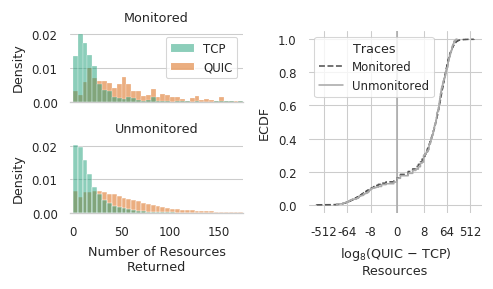

In [9]:
def plot(monitored, unmonitored):
    with plt.style.context([
        "mpl-style/pets.mplstyle",  "mpl-style/white-grid.mplstyle",
    ]):
        figure = plt.figure(constrained_layout=True, figsize=(4, 2.3), dpi=120)
        spec = figure.add_gridspec(2, 2)
        axes = [figure.add_subplot(spec[0, 0])]
        axes.append(figure.add_subplot(spec[1, 0], sharex=axes[0]))
        axes.append(figure.add_subplot(spec[:, 1]))
                     
        plt.setp(axes[0].get_xticklabels(), visible=False)
    
        plot_histogram(monitored, axes[0])
        axes[0].set_title("Monitored")
        axes[0].set_xlim(-3, 175)
        
        plot_histogram(unmonitored, axes[1])
        axes[1].set_title("Unmonitored")
        axes[1].get_legend().remove()
        
        plot_ecdf(monitored, unmonitored, axes[2])
        
    return figure
        

figure = plot(monitored, unmonitored)
figure.savefig(PLOT, dpi=150, bbox_inches="tight")